In [3]:
import pandas as pd
from datetime import datetime, date, time, timedelta
import numpy as np

import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.formula.api as smf  
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as sc

from itertools import product   
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt                  
import seaborn as sns                            
sns.set()
%matplotlib inline

import warnings                                
warnings.filterwarnings('ignore')

## 1. Подготовка данных

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [3]:
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.tail(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.334264,44.789133,0.0,0.00,0.00,0.000,9831.30
snow_1h,48204.0,0.000222,0.008168,0.0,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.0,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.0,1193.00,3380.00,4933.000,7280.00


 Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Столбец 'date_time' имеет формат 'object', но мы знаем, что это дата и время, поэтому приведем его к формату 'datetime'

In [7]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [8]:
df.dtypes

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                      int64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                  int64
dtype: object

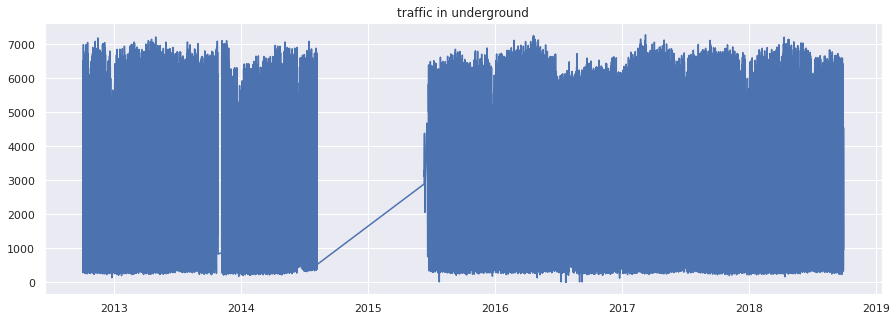

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(df['date_time'], df['traffic_volume'])
plt.title('traffic in underground')
plt.show()

Похоже в 2014-2015 году данную станцию метро закрыли на ремонт или что-то ещё. Итого наш ряд - нарушен, поэтому возьмем значения, начиная с 1 октября 2015 года (так у нас останется ровно 3 года наблюдений)

In [10]:
df[df['date_time']=='2015-10-01 00:00:00'].index

Int64Index([18702], dtype='int64')

In [11]:
df_new = df.loc[18702:, :]

In [12]:
df_new

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
18702,None,279.62,0.0,0.0,1,Clear,sky is clear,2015-10-01 00:00:00,544
18703,None,278.85,0.0,0.0,1,Clear,sky is clear,2015-10-01 01:00:00,380
18704,None,278.88,0.0,0.0,1,Clear,sky is clear,2015-10-01 02:00:00,298
18705,None,278.89,0.0,0.0,1,Clear,sky is clear,2015-10-01 03:00:00,373
18706,None,278.60,0.0,0.0,1,Clear,sky is clear,2015-10-01 04:00:00,918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


Посмотрим на графики в каждом году:

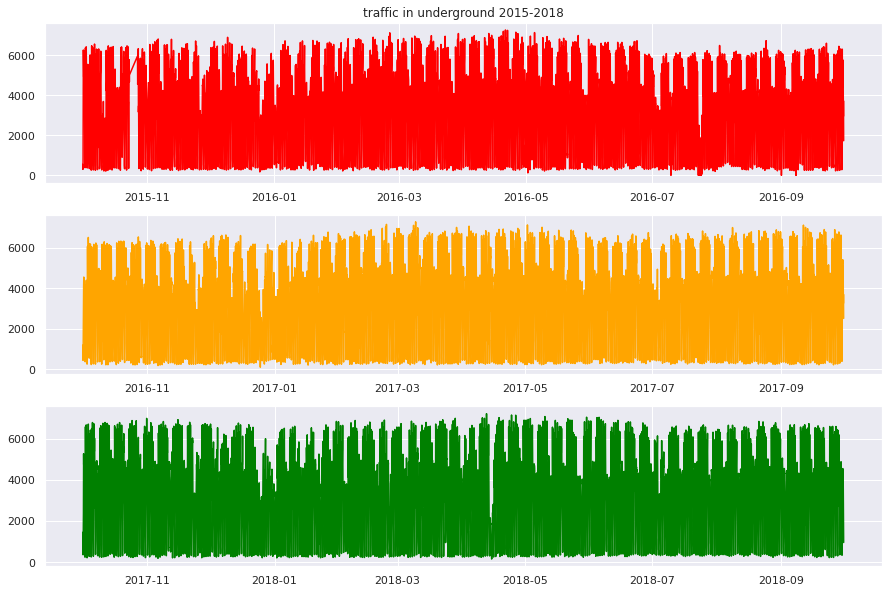

In [13]:
df_new_2015 = df_new.query("date_time >= '2015-10-01 00:00:00' & date_time < '2016-10-01 00:00:00'")
df_new_2016 = df_new.query("date_time >= '2016-10-01 00:00:00' & date_time < '2017-10-01 00:00:00'")
df_new_2017 = df_new.query("date_time >= '2017-10-01 00:00:00' & date_time < '2018-10-01 00:00:00'")

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.title('traffic in underground 2015-2018')
plt.plot(df_new_2015['date_time'], df_new_2015['traffic_volume'], color = 'red')
plt.subplot(3, 1, 2)
plt.plot(df_new_2016['date_time'], df_new_2016['traffic_volume'], color = 'orange')
plt.subplot(3, 1, 3)
plt.plot(df_new_2017['date_time'], df_new_2017['traffic_volume'], color = 'green')

plt.show()

По графикам видно 52 пика, что соответствует количеству недель в году. Но в графиках есть странные 'выпады' - надо подробнее посмотреть данные.

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29502 entries, 18702 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              29502 non-null  object        
 1   temp                 29502 non-null  float64       
 2   rain_1h              29502 non-null  float64       
 3   snow_1h              29502 non-null  float64       
 4   clouds_all           29502 non-null  int64         
 5   weather_main         29502 non-null  object        
 6   weather_description  29502 non-null  object        
 7   date_time            29502 non-null  datetime64[ns]
 8   traffic_volume       29502 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 2.0+ MB


Проверим уникальность временных показателей:

In [15]:
print('Количество строк -', str(len(df_new))+',',\
      'Количество уникальных дат -', len(set(df_new['date_time'])))

Количество строк - 29502, Количество уникальных дат - 24406


Количество строк и дат не сходится, найдем повторения:

In [16]:
all_date_time = []
repeat_date_time = []
repeat_index = []
for i in tqdm(df_new.index):
    k = df_new.loc[i, 'date_time']
    if k not in all_date_time:
        all_date_time.append(k)
    else:
        repeat_date_time.append(k)
        repeat_index.append(i)

Посмотрим на повторяющиеся строки:

In [17]:
df_new[df_new['date_time'] == repeat_date_time[0]]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
18831,None,277.19,0.0,0.0,1,Mist,mist,2015-10-07 06:00:00,6039
18832,None,277.19,0.0,0.0,1,Fog,fog,2015-10-07 06:00:00,6039


In [18]:
df_new[df_new['date_time'] == repeat_date_time[100]]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
19434,None,280.08,0.0,0.0,90,Rain,moderate rain,2015-11-12 01:00:00,293
19435,None,280.08,0.0,0.0,90,Mist,mist,2015-11-12 01:00:00,293
19436,None,280.08,0.0,0.0,90,Snow,light snow,2015-11-12 01:00:00,293


Целевая переменная не изменяется, в основном повторения показывают разное состояние погоды (причем численные показатели не меняются). Поэтому можно попробовать их просто удалить. Но есть ещё одна проблема - не все данные содержат время. С этим надо тоже что-то сделать

In [19]:
df_without_repeat = df_new.copy()
df_without_repeat = df_without_repeat.drop(repeat_index, axis = 0)

In [20]:
df_without_repeat = df_without_repeat.set_index(i for i in range(len(df_without_repeat)))

In [21]:
print('Количество строк -', str(len(df_without_repeat))+',',\
      'Количество уникальных дат -', len(set(df_without_repeat['date_time'])))

Количество строк - 24406, Количество уникальных дат - 24406


In [22]:
df_without_repeat.head(20)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,279.62,0.0,0.0,1,Clear,sky is clear,2015-10-01 00:00:00,544
1,None,278.85,0.0,0.0,1,Clear,sky is clear,2015-10-01 01:00:00,380
2,None,278.88,0.0,0.0,1,Clear,sky is clear,2015-10-01 02:00:00,298
3,None,278.89,0.0,0.0,1,Clear,sky is clear,2015-10-01 03:00:00,373
4,None,278.60,0.0,0.0,1,Clear,sky is clear,2015-10-01 04:00:00,918
5,None,278.27,0.0,0.0,1,Clear,sky is clear,2015-10-01 05:00:00,2922
6,None,277.75,0.0,0.0,1,Clear,sky is clear,2015-10-01 07:00:00,6258
7,None,286.75,0.0,0.0,1,Clear,sky is clear,2015-10-01 11:00:00,4925
8,None,288.25,0.0,0.0,1,Clear,sky is clear,2015-10-01 12:00:00,5157
9,None,289.29,0.0,0.0,1,Clear,sky is clear,2015-10-01 13:00:00,5141


В данных мы видим, что не все значения отстают друг от друга на час. Это плохо. Исправим при помощь библиотеки datetime

In [23]:
df_for_analysis = pd.DataFrame(columns=df_without_repeat.columns)

In [24]:
j = 0
for i in tqdm(range(len(df_without_repeat.index)-1)):
    hour_1 = df_without_repeat.loc[i, 'date_time']
    hour_2 = df_without_repeat.loc[i+1, 'date_time']
    if (hour_2-hour_1).seconds == 3600:
        df_for_analysis.loc[j, :] = df_without_repeat.loc[i, :]
        j +=1
    else:
        delta = int((hour_2-hour_1).seconds/3600)-1
        df_for_analysis.loc[j, :] = df_without_repeat.loc[i, :]
        j +=1
        time_td = df_without_repeat.loc[i, 'date_time']
        for z in range(delta):
            df_for_analysis.loc[j, 'date_time'] = time_td+pd.Timedelta('1 hour')
            time_td += pd.Timedelta('1 hour')
            j+=1

In [25]:
df_for_analysis.head(24)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,279.62,0,0,1,Clear,sky is clear,2015-10-01 00:00:00,544
1,None,278.85,0,0,1,Clear,sky is clear,2015-10-01 01:00:00,380
2,None,278.88,0,0,1,Clear,sky is clear,2015-10-01 02:00:00,298
3,None,278.89,0,0,1,Clear,sky is clear,2015-10-01 03:00:00,373
4,None,278.6,0,0,1,Clear,sky is clear,2015-10-01 04:00:00,918
5,None,278.27,0,0,1,Clear,sky is clear,2015-10-01 05:00:00,2922
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01 06:00:00,NaN
7,None,277.75,0,0,1,Clear,sky is clear,2015-10-01 07:00:00,6258
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01 08:00:00,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-01 09:00:00,NaN


In [26]:
df_for_analysis.dtypes

holiday                object
temp                   object
rain_1h                object
snow_1h                object
clouds_all             object
weather_main           object
weather_description    object
date_time              object
traffic_volume         object
dtype: object

In [27]:
for i in ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']:
    df_for_analysis[i] = df_for_analysis[i].astype('float')
df_for_analysis['date_time'] = pd.to_datetime(df_for_analysis['date_time'])

In [28]:
df_for_analysis.dtypes

holiday                        object
temp                          float64
rain_1h                       float64
snow_1h                       float64
clouds_all                    float64
weather_main                   object
weather_description            object
date_time              datetime64[ns]
traffic_volume                float64
dtype: object

In [29]:
for i in df_for_analysis.columns:
    if df_for_analysis[i].dtype == 'float64':
        df_for_analysis[i] = df_for_analysis[i].interpolate()

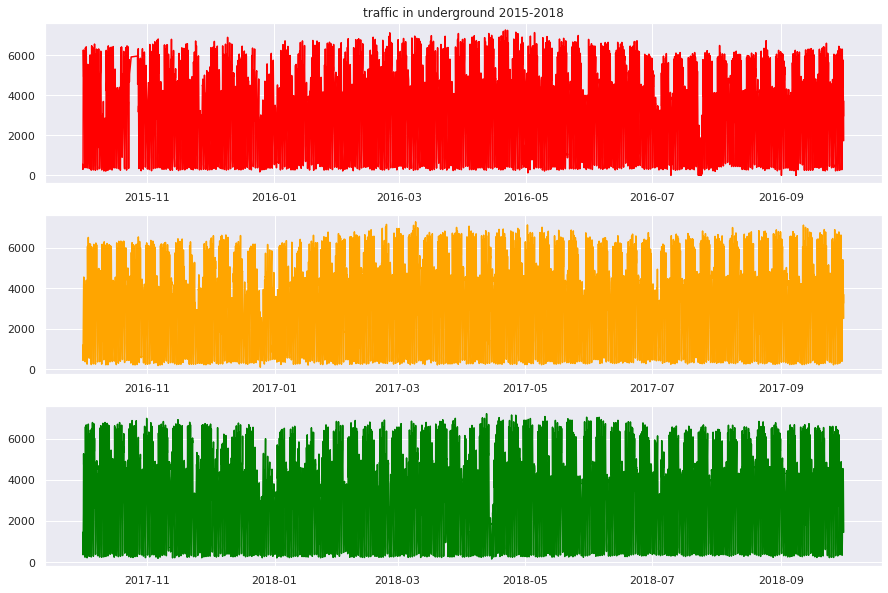

In [30]:
df_2015 = df_for_analysis.query("date_time >= '2015-10-01 00:00:00' & date_time < '2016-10-01 00:00:00'")
df_2016 = df_for_analysis.query("date_time >= '2016-10-01 00:00:00' & date_time < '2017-10-01 00:00:00'")
df_2017 = df_for_analysis.query("date_time >= '2017-10-01 00:00:00' & date_time < '2018-10-01 00:00:00'")

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.title('traffic in underground 2015-2018')
plt.plot(df_2015['date_time'], df_2015['traffic_volume'], color = 'red')
plt.subplot(3, 1, 2)
plt.plot(df_2016['date_time'], df_2016['traffic_volume'], color = 'orange')
plt.subplot(3, 1, 3)
plt.plot(df_2017['date_time'], df_2017['traffic_volume'], color = 'green')

plt.show()

В конце октября 2015 года по графику странные данные, посмотрим это место ближе:

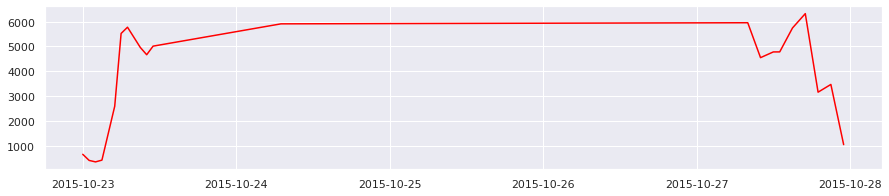

In [31]:
df_2015_1 = df_for_analysis.query("date_time >= '2015-10-23 00:00:00' & date_time < '2015-10-28 00:00:00'")
plt.figure(figsize=(15, 3))
plt.plot(df_2015_1['date_time'], df_2015_1['traffic_volume'], color = 'red')

Так как нам нужно будет сделать прогноз на несколько недель октября 2018 года - луше убрать эти данные из выборки. Попробуем оставить данные только за последние 2 года

In [32]:
df_final = df_for_analysis.copy()
df_final = df_final.loc[8712:, :]
df_final = df_final.set_index(i for i in range(len(df_final)))

In [33]:
df_final.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,17519.000000,17519.000000,17519.0,17519.000000,17519.000000
mean,281.378540,0.025570,0.0,42.169188,3318.059079
std,12.724802,0.260029,0.0,39.129634,1967.399108
min,243.390000,0.000000,0.0,0.000000,113.000000
25%,272.150000,0.000000,0.0,1.000000,1302.000000
50%,282.360000,0.000000,0.0,40.000000,3512.000000
75%,291.940000,0.000000,0.0,90.000000,4940.000000
max,310.070000,10.600000,0.0,100.000000,7280.000000


Мы видим, что за последние два года нет сведений о снеге (наверное из-за глобального потепления). Удалим этот столбец

In [34]:
df_final = df_final.drop(['snow_1h'], axis=1)

Добавим к нашим данным ещё пару фичей - день недели, час дня, выходной или будний день (для графика 5/2)

In [35]:
df_final['time'] = df_final['date_time'].map(lambda x: x.timetuple()[3])
df_final['weekday'] = df_final['date_time'].map(lambda x: x.timetuple()[6])
df_final['day_off'] = df_final['weekday'].map(lambda x: 1 if x in [5,6] else 0)

In [36]:
df_final

,holiday,temp,rain_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,time,weekday,day_off
0,None,286.22,0.00,20.0,Clouds,few clouds,2016-10-01 00:00:00,1195.0,0,5,1
1,None,285.60,0.00,20.0,Clouds,few clouds,2016-10-01 01:00:00,776.0,1,5,1
2,None,285.49,0.00,56.0,Clouds,broken clouds,2016-10-01 02:00:00,666.0,2,5,1
3,None,284.59,0.00,56.0,Clouds,broken clouds,2016-10-01 03:00:00,448.0,3,5,1
4,None,284.26,0.00,56.0,Clouds,broken clouds,2016-10-01 04:00:00,512.0,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...
17514,None,284.20,0.25,75.0,Rain,light rain,2018-09-30 18:00:00,3947.0,18,6,1
17515,None,283.45,0.00,75.0,Clouds,broken clouds,2018-09-30 19:00:00,3543.0,19,6,1
17516,None,282.76,0.00,90.0,Clouds,overcast clouds,2018-09-30 20:00:00,2781.0,20,6,1
17517,None,282.73,0.00,90.0,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159.0,21,6,1


Необходимо доделать все преобразования с датасетом и заполнить недостающие данные. Однако у нас есть строки, которые мы генерировали при восстановлении временных рядов по часам. Было бы неплохо их тоже как нибудь осознанно заполнить. Создадим дубликаты столбцов с типом 'object', преобразуем их с помощью fillna и labelencoder, потом вернем эти значения в оригинальные столбцы и интерполяцией заполним недостающие значения

In [37]:
labelencoder = LabelEncoder()
for ncol in df_final.select_dtypes(include=['object']).columns:
    name = str(ncol)+'_copy'
    df_final[name] = df_final[ncol]
    df_final[name] = df_final[name].fillna('-')
    df_final[name] = labelencoder.fit_transform(df_final[name])
    df_final[ncol] = df_final[name].map(lambda x: x if x != None else None)
    df_final[ncol] = df_final[ncol].interpolate()
    df_final = df_final.drop([name], axis=1)

In [38]:
df_final.isnull().sum()

holiday                0
temp                   0
rain_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
time                   0
weekday                0
day_off                0
dtype: int64

В заключение нашей подготовки данных - заменим индексы на значения 'date_time'

In [39]:
df_final = df_final.set_index('date_time')

In [40]:
pickle.dump(df_final, open('df_final.pckl', 'wb'))

In [41]:
df = pickle.load(open('df_final.pckl', 'rb'))

Данные готовы. Теперь было бы неплохо проверить наш ряд на стационарность. Проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [42]:
test = sm.tsa.adfuller(df['traffic_volume'])
print('adf: ', test[0] )
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен, ура!')

adf:  -16.136162775143486
p-value:  4.7287067142032395e-29
Critical values:  {'1%': -3.4307242852745428, '5%': -2.8617054196196627, '10%': -2.566858048572343}
единичных корней нет, ряд стационарен, ура!


Так как ряд стационарен - нет необходимости проводить танцы с бубном для приведения его к требуемому виду, начнем моделирование. Отложим данные последних 2х недель для дальнейшей валидации

In [43]:
df_valid = df.loc['2018-09-16 00:00:00':, :] 
df_train = df.drop(df_valid.index, axis=0)

## 2. Выбор метрики

Нам необходимо создать baseline для наших предсказаний. Посчитаем средние значения по часам и по дням недели на и будем использовать эти данные для в качестве прогноза на отложенную выборку. Метрикой качества выберем среднюю абсолютную ошибку в процентах:

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

In [15]:
def MAPE_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
baseline = df_train.groupby(['weekday', 'time'])['traffic_volume'].mean().reset_index()
valid_for_baseline = df_valid['traffic_volume'].head(168).reset_index()

In [46]:
MAPE_error(valid_for_baseline['traffic_volume'], baseline['traffic_volume'])

26.463237526937768

Ошибка, конечно, большая, поэтому будем её уменьшать. Начнем с модели линейной регрессии. 

## 3. Построение модели линейной регрессии для временных рядов

Нам нужны признаки - воспользуемся лагами временного ряда. Если мы хотим делать предсказание на неделю вперед - нам нужно брать лаги недельной давности, то есть отступить на 168 часов. Также мы знаем, что в течение дня также есть своя зависимость - поэтому дадим модели фичи по лагам [-(168+25):-168]

In [47]:
for i in range(168, 193):
    df["lag_{}".format(i)] = df['traffic_volume'].shift(i)

In [48]:
df = df.drop(df.index[0:192], axis = 0)

In [49]:
df_valid = df.loc['2018-09-16 00:00:00':, :] 
df_train = df.drop(df_valid.index, axis=0)

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [51]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [52]:
y = df_train['traffic_volume']
X = df_train.drop(['traffic_volume'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
lr1_error = MAPE_error(y_test, prediction)
lr1_error

20.42804426769719

In [54]:
y_lr_valid = df_valid['traffic_volume'].head(168)
df_lr_valid = df_valid.drop(['traffic_volume'], axis=1)
df_lr_valid = df_lr_valid.head(168)
valid_prediction = lr.predict(df_lr_valid)
valid_error = MAPE_error(y_lr_valid, valid_prediction)
valid_error

16.691357835615957

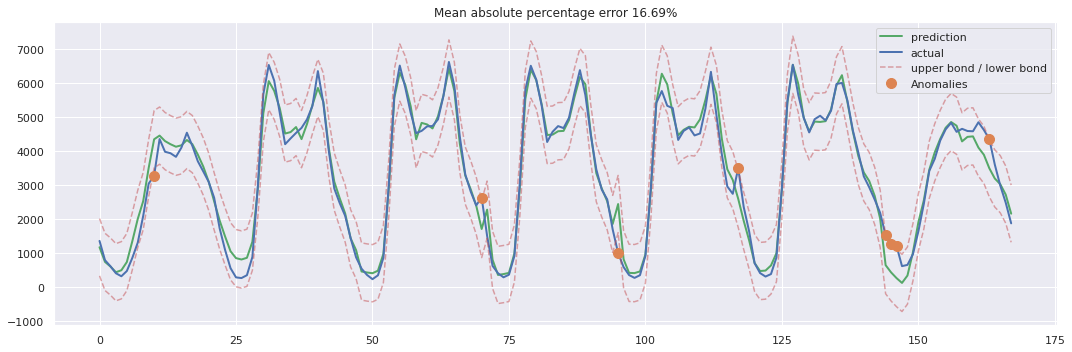

In [55]:
plt.figure(figsize=(15, 5))
plt.plot(valid_prediction, "g", label="prediction", linewidth=2.0)
plt.plot(y_lr_valid.values, label="actual", linewidth=2.0)

cv = cross_val_score(lr, df_lr_valid, y_lr_valid, cv=tscv, scoring="neg_mean_absolute_error")
mae = cv.mean() * (-1)
deviation = cv.std()
        
scale = 1.96
lower = valid_prediction - (mae + scale * deviation)
upper = valid_prediction + (mae + scale * deviation)
        
plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
plt.plot(upper, "r--", alpha=0.5)

anomalies = np.array([np.NaN]*len(y_lr_valid))
anomalies[y_lr_valid<lower] = y_lr_valid[y_lr_valid<lower]
anomalies[y_lr_valid>upper] = y_lr_valid[y_lr_valid>upper]
plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

plt.title("Mean absolute percentage error {0:.2f}%".format(valid_error))
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)


Посмотрим на важность признаков в нашей модели:

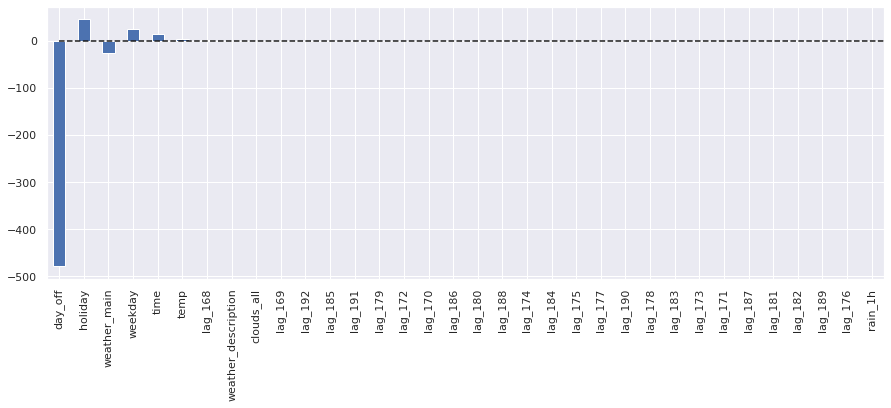

In [56]:
coefs = pd.DataFrame(lr.coef_, X_train.columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
plt.figure(figsize=(15, 5))
coefs.coef.plot(kind='bar')
plt.grid(True, axis='y')
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

### 3.1 Нормализация признаков

Ошибка на валидационной выборке ниже, чем наш baseline. По важности признаков наши лаги никак практически не влияли на результаты модели. Стоит вспомнить, что линейные модели достаточно чувствительны к размерности, поэтому необходимо провести нормализацию признаков

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [58]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr2 = LinearRegression()
lr2.fit(X_train_scaled, y_train)
prediction_2 = lr2.predict(X_test_scaled)
lr2_error = MAPE_error(y_test, prediction_2)
lr2_error

20.428044267701033

In [59]:
y_lr_valid = df_valid['traffic_volume'].head(168)
df_lr_valid = df_valid.drop(['traffic_volume'], axis=1)
df_lr_valid = df_lr_valid.head(168)
df_lr_valid_scaled = scaler.fit_transform(df_lr_valid)
valid_prediction2 = lr2.predict(df_lr_valid_scaled)
valid_error2 = MAPE_error(y_lr_valid, valid_prediction2)
valid_error2

15.838039128028344

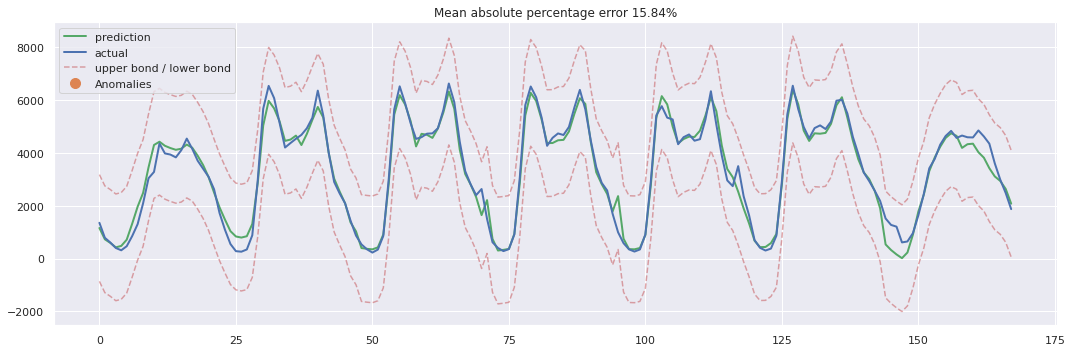

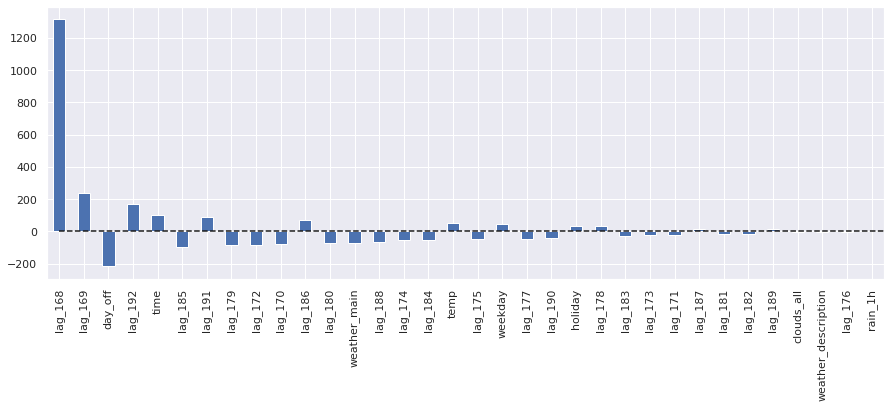

In [60]:
plt.figure(figsize=(15, 5))
plt.plot(valid_prediction2, "g", label="prediction", linewidth=2.0)
plt.plot(y_lr_valid.values, label="actual", linewidth=2.0)

cv = cross_val_score(lr2, df_lr_valid_scaled, y_lr_valid, cv=tscv, scoring="neg_mean_absolute_error")
mae = cv.mean() * (-1)
deviation = cv.std()
        
scale = 1.96
lower = valid_prediction2 - (mae + scale * deviation)
upper = valid_prediction2 + (mae + scale * deviation)
        
plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
plt.plot(upper, "r--", alpha=0.5)

anomalies = np.array([np.NaN]*len(y_lr_valid))
anomalies[y_lr_valid<lower] = y_lr_valid[y_lr_valid<lower]
anomalies[y_lr_valid>upper] = y_lr_valid[y_lr_valid>upper]
plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

plt.title("Mean absolute percentage error {0:.2f}%".format(valid_error2))
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)


coefs = pd.DataFrame(lr2.coef_, X_train.columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
plt.figure(figsize=(15, 5))
coefs.coef.plot(kind='bar')
plt.grid(True, axis='y')
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

Ошибка уменьшилась, но мы видим слишком большое значение коэффициента при параметре 'lag_168'. Применим к ней регуляризацию

### 3.2 Регуляризация модели

In [61]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train_scaled, y_train)

lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train_scaled, y_train)
lasso_prediction = lasso.predict(df_lr_valid_scaled)

ridge_error = MAPE_error(y_lr_valid, ridge.predict(df_lr_valid_scaled))
lasso_error = MAPE_error(y_lr_valid, lasso.predict(df_lr_valid_scaled))

print("MAPE ridge {0:.3f}%".format(ridge_error), "MAPE lasso {0:.3f}%".format(lasso_error))


MAPE ridge 15.868% MAPE lasso 14.259%


После нормализации признаков и регуляризации нашей линейной модели мы получили значение MAPE 14.259% против 26.463% по baseline

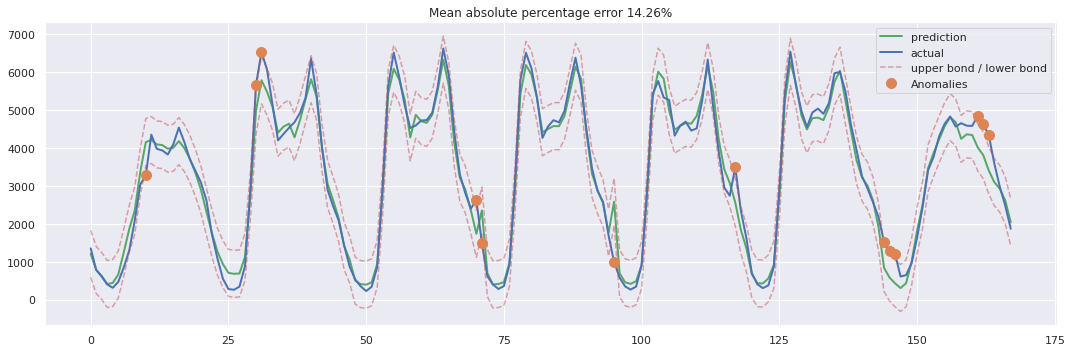

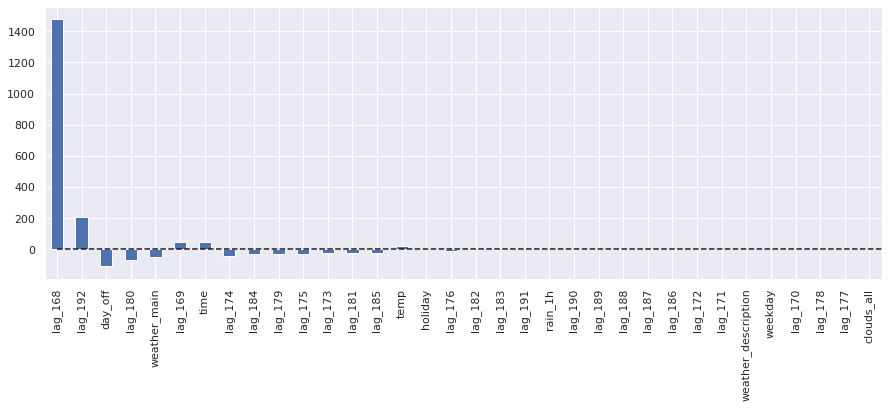

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(lasso_prediction, "g", label="prediction", linewidth=2.0)
plt.plot(y_lr_valid.values, label="actual", linewidth=2.0)

cv = cross_val_score(lasso, df_lr_valid_scaled, y_lr_valid, cv=tscv, scoring="neg_mean_absolute_error")
mae = cv.mean() * (-1)
deviation = cv.std()
        
scale = 1.96
lower = lasso_prediction - (mae + scale * deviation)
upper = lasso_prediction + (mae + scale * deviation)
        
plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
plt.plot(upper, "r--", alpha=0.5)

anomalies = np.array([np.NaN]*len(y_lr_valid))
anomalies[y_lr_valid<lower] = y_lr_valid[y_lr_valid<lower]
anomalies[y_lr_valid>upper] = y_lr_valid[y_lr_valid>upper]
plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

plt.title("Mean absolute percentage error {0:.2f}%".format(lasso_error))
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)


coefs = pd.DataFrame(lasso.coef_, X_train.columns)
coefs.columns = ["coef"]
coefs["abs"] = coefs.coef.apply(np.abs)
coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
plt.figure(figsize=(15, 5))
coefs.coef.plot(kind='bar')
plt.grid(True, axis='y')
plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

## 4 Построение моделей на основе деревьев принятия решений

Перейдем к деревянным методам. Рассмотрим случайный лес (RandomForest), градиентный бустинг (GradientBoosting), а так же CatBoost

In [63]:
from sklearn.ensemble import RandomForestRegressor

for i in range(25, 101, 25):
    rf = RandomForestRegressor(n_estimators=i, random_state=23, n_jobs=4)
    rf.fit(X_train_scaled, y_train)
    rf_prediction = rf.predict(df_lr_valid_scaled)
    rf_error = MAPE_error(y_lr_valid, rf_prediction)
    print('n_estimators = ', i, "MAPE RandomForest {0:.3f}%".format(rf_error))

n_estimators =  25 MAPE RandomForest 13.741%
n_estimators =  50 MAPE RandomForest 13.333%
n_estimators =  75 MAPE RandomForest 13.232%
n_estimators =  100 MAPE RandomForest 13.071%


In [64]:
from sklearn.ensemble import GradientBoostingRegressor

for i in range(25, 101, 25):
    gbr = GradientBoostingRegressor(n_estimators=i, learning_rate=1.0, random_state=23)
    gbr.fit(X_train_scaled, y_train)
    gbr_prediction = gbr.predict(df_lr_valid_scaled)
    gbr_error = MAPE_error(y_lr_valid, gbr_prediction)
    print('n_estimators = ', i, "MAPE GradientBoosting {0:.3f}%".format(gbr_error))

n_estimators =  25 MAPE GradientBoosting 14.599%
n_estimators =  50 MAPE GradientBoosting 16.198%
n_estimators =  75 MAPE GradientBoosting 16.657%
n_estimators =  100 MAPE GradientBoosting 21.280%


In [65]:
from catboost import CatBoostRegressor

for i in range(25, 101, 25):
    catboost = CatBoostRegressor(iterations=i, learning_rate=0.7, loss_function='RMSE', verbose=0)
    catboost.fit(X_train_scaled, y_train, verbose=0)
    catboost_prediction = catboost.predict(df_lr_valid_scaled)
    catboost_error = MAPE_error(y_lr_valid, catboost_prediction)
    print('n_estimators = ', i, "MAPE catboost {0:.3f}%".format(catboost_error))


n_estimators =  25 MAPE catboost 10.627%
n_estimators =  50 MAPE catboost 10.591%
n_estimators =  75 MAPE catboost 11.771%
n_estimators =  100 MAPE catboost 12.389%


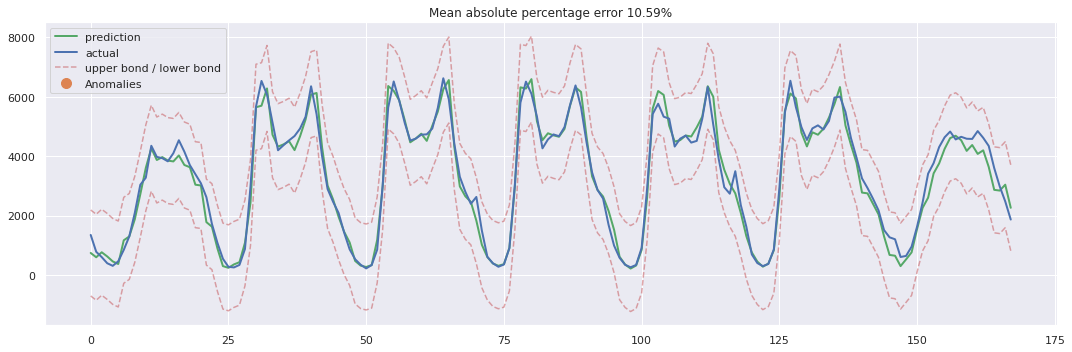

In [66]:
catboost = CatBoostRegressor(iterations=50, learning_rate=0.7, loss_function='RMSE', verbose=0)
catboost.fit(X_train_scaled, y_train, verbose=0)
catboost_prediction = catboost.predict(df_lr_valid_scaled)
catboost_error = MAPE_error(y_lr_valid, catboost_prediction)

plt.figure(figsize=(15, 5))
plt.plot(catboost_prediction, "g", label="prediction", linewidth=2.0)
plt.plot(y_lr_valid.values, label="actual", linewidth=2.0)

cv = cross_val_score(catboost, df_lr_valid_scaled, y_lr_valid, cv=tscv, scoring="neg_mean_absolute_error")
mae = cv.mean() * (-1)
deviation = cv.std()
        
scale = 1.96
lower = catboost_prediction - (mae + scale * deviation)
upper = catboost_prediction + (mae + scale * deviation)
        
plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
plt.plot(upper, "r--", alpha=0.5)

anomalies = np.array([np.NaN]*len(y_lr_valid))
anomalies[y_lr_valid<lower] = y_lr_valid[y_lr_valid<lower]
anomalies[y_lr_valid>upper] = y_lr_valid[y_lr_valid>upper]
plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

plt.title("Mean absolute percentage error {0:.2f}%".format(catboost_error))
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)

## 5. Построение модели SARIMA

Попробуем построить модель SARIMA. Для подбора коэффициэнтов необходимо построить графики автокорреляции и частной автокорреляции.

In [7]:
df = pickle.load(open('df_final.pckl', 'rb'))
df_valid = df.loc['2018-09-16 00:00:00':, :] 
df_train = df.drop(df_valid.index, axis=0)

In [68]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)   
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

Посмотрим на графики для 200 лагах (это чуть больше недели)

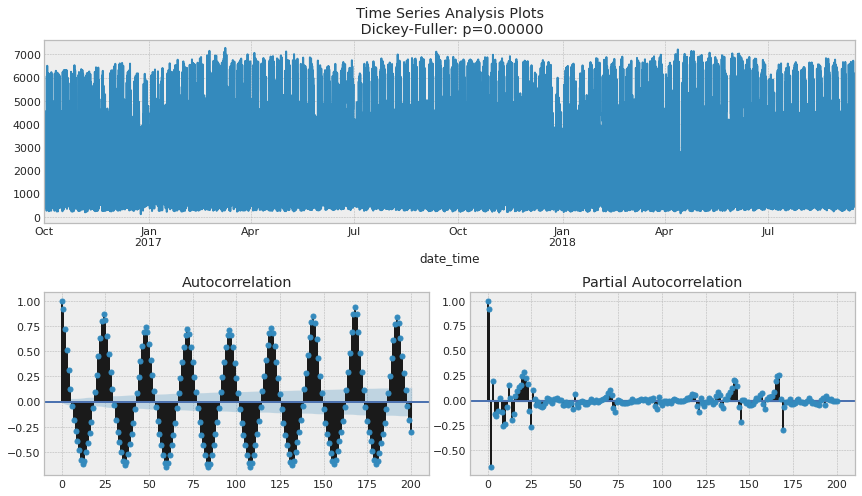

In [69]:
tsplot(df_train['traffic_volume'], lags=200)

Видно, что на графике автокорреляции проявляется 2 сезонности - недельная и суточная. Модель SARIMA учитывает только одну сезонность, поэтому попробуем избавиться от наиболее сильной - от "сезонности" в течение суток. Посмотрим на суточный график поближе: 

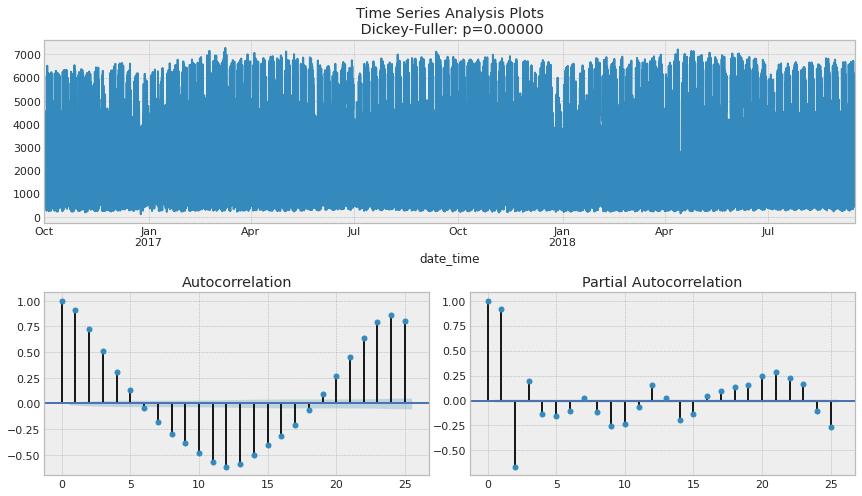

In [70]:
tsplot(df_train['traffic_volume'], lags=25)

Попробуем избавиться от автокорреляции. Для начала вычтем из нашего временого ряда этот же ряд, но со смешением на неделю:

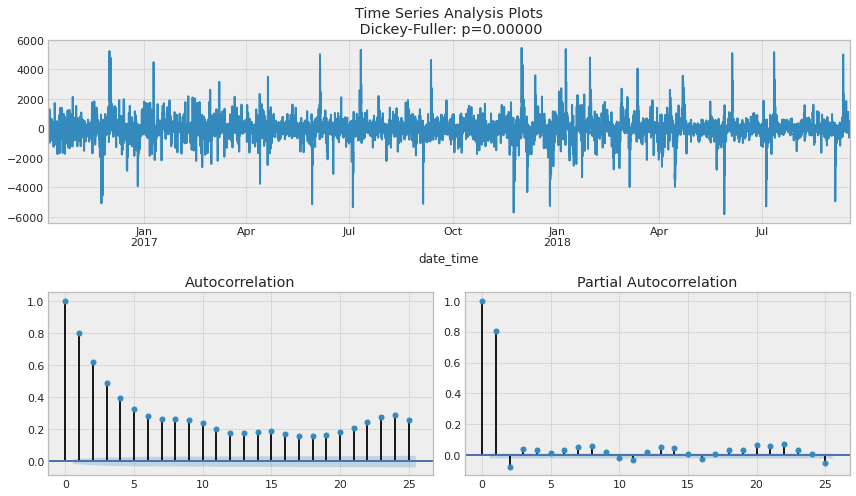

In [71]:
diff = df_train['traffic_volume'] - df_train['traffic_volume'].shift(168)
tsplot(diff[168:], lags=25)

Вроде лучше, но не идеально, вычтем сутки, а затем первые разности:

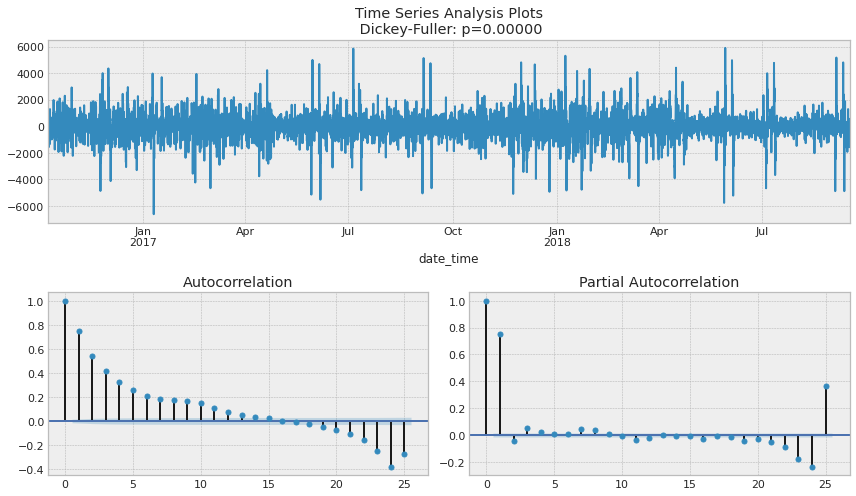

In [72]:
diff_day = diff - diff.shift(24)
tsplot(diff_day[192:], lags=25)

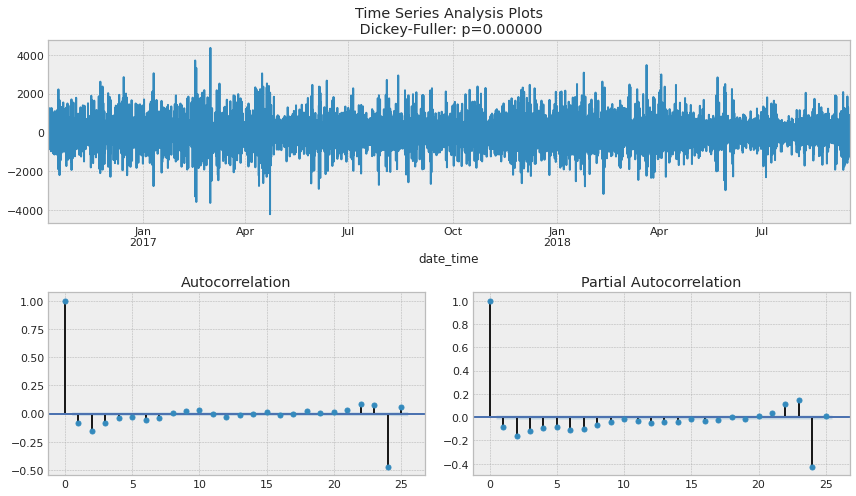

In [73]:
diff_hour = diff_day - diff_day.shift(1)
tsplot(diff_hour[193:], lags=25)

График, конечно, не фонтан, но попробуем поработать с ним.

Нам необходимо подобрать 7 параметров:
1. p - максимальный лаг частной автокорреляции, определяется по графику автокорреляции
2. d - порядок интегрированности временного ряда, то есть количество простых разностей, которое нам потребовалось, чтобы ряд стал стационарным. В нашем случае ряд был изначально стационарен, но мы один раз вычли первые разности, чтобы снизить автокорреляцию
3. q - модель скользящего среднего или случайные ошибки временного ряда,начальное значение определяется по графику автокорреляции
4. P - число значимых лагов, кратных периоду сезонности
5. D = порядок сезонной интегрированности временного ряда. Может быть равен либо 0, либо 1, так как сезонное дифференцирование либо проводилось, либо нет
6. Q = число значимых лагов, кратных периоду сезонности для частной автокорреляции
7. s = длина периода сезонности во временном ряде

Для подбора модели некоторые параметры будем брать в интервалах.

In [4]:
# setting initial values and some bounds for them
ps = range(2, 4)
d = 1
qs = range(2, 4)
Ps = range(0, 3)
D = 1 
Qs = range(0, 3)
s = 168 

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [5]:
def optimizeSARIMA(parameters_list, d, D, s):
    
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_train['traffic_volume'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        print("aic {0:.3f}%".format(aic))
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])


    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [ ]:
result_table.head()

Подбор параметров ведет себя странно - продолжим чуть позже...

## 6. Нейронные сети для временных рядов 

Тут тоже заготовка, будут дополнения...

In [8]:
from fbprophet import Prophet

In [17]:
predictions = 168

#creating a specific format dataset 
#df = df.reset_index()
df1 = pd.DataFrame(df[['date_time', 'traffic_volume']])
df1.columns = ['ds', 'y']
df1.tail()

,ds,y
17514,2018-09-30 18:00:00,3947.0
17515,2018-09-30 19:00:00,3543.0
17516,2018-09-30 20:00:00,2781.0
17517,2018-09-30 21:00:00,2159.0
17518,2018-09-30 22:00:00,1450.0


In [18]:
train_df = df1[:-predictions]

In [23]:
model = Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=True)
model.fit(train_df)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='H')
future.tail()

,ds
17514,2018-09-30 18:00:00
17515,2018-09-30 19:00:00
17516,2018-09-30 20:00:00
17517,2018-09-30 21:00:00
17518,2018-09-30 22:00:00


In [24]:
forecast = model.predict(future)
forecast.tail().T

,17514,17515,17516,17517,17518
ds,2018-09-30 18:00:00,2018-09-30 19:00:00,2018-09-30 20:00:00,2018-09-30 21:00:00,2018-09-30 22:00:00
trend,3293.5,3293.49,3293.49,3293.48,3293.48
yhat_lower,3031.72,2292.4,1575.1,1033.8,741.443
yhat_upper,5217.29,4345.7,3631.89,3175.21,2912.34
trend_lower,3293.5,3293.49,3293.49,3293.48,3293.48
trend_upper,3293.5,3293.49,3293.49,3293.48,3293.48
additive_terms,839.424,47.8891,-659.153,-1125.43,-1412.85
additive_terms_lower,839.424,47.8891,-659.153,-1125.43,-1412.85
additive_terms_upper,839.424,47.8891,-659.153,-1125.43,-1412.85
daily,1163.57,340.508,-398.644,-897.416,-1217.52


In [25]:
error = MAPE_error(df1[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
#_ = model.plot(forecast[-predictions:])

Mean absolute percentage error 42.38%
